<a href="https://www.kaggle.com/code/seanandrie/ps-s4-e01-adaptive-weighted-ensemble?scriptVersionId=166976227" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

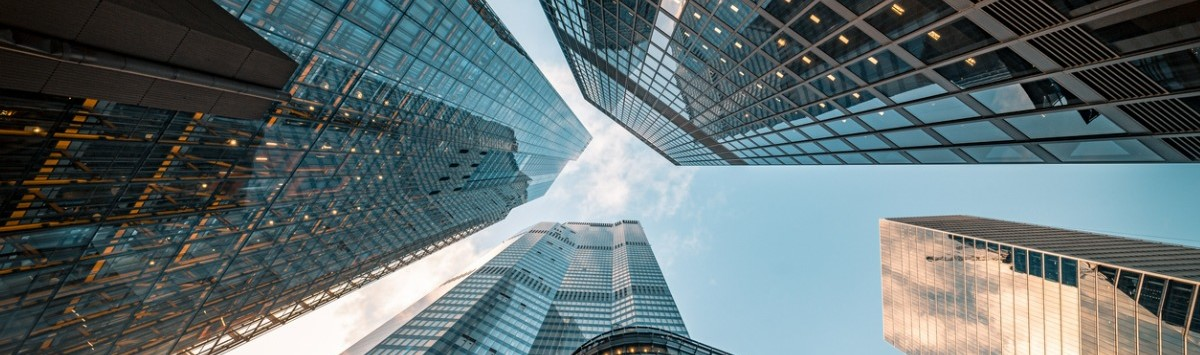

<h1 style = 'text-align: center; font-family: Ebrima'><b><u>Binary Classification with Churn Dataset</u></b></h1>

<div style = 'font-family: Ebrima'>
    <h2>
        — Introduction
    </h2>
    <hr>
    <p style = 'font-size:16px'>
        <b><i>Bank churn</i></b>, also known as <b><i>customer churn</i></b> or <b><i>attrition</i></b>, refers to the phenomenon where customers discontinue their relationship with a bank, typically by closing their accounts or reducing their engagement with banking services. Understanding and managing bank churn is crucial for financial institutions as retaining existing customers is often more cost-effective than acquiring new ones. In this project, I will be using binary classification techniques in order to predict a customer's probability of churning by testing a variety of machine learning algorithms and selecting the best performing ones to create an ensemble. I will also be using Optuna to tune their hyperparameters accordingly.
    </p>
    <h2>
        — About Dataset
    </h2>
    <hr>
    <p style = 'font-size:16px'>
        The commonly utilized bank customer churn dataset serves as a valuable resource for forecasting customer turnover within the banking sector. This particular dataset provided by Kaggle for this Playground Series Competition, comprises details regarding customers who have either discontinued their association with the bank or those who remain active customers. This synthetic dataset was created from the <a href="https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction">Bank Customer Churn Prediction</a> dataset by Shubham Meshram.
    </p>
    <h4><b>Attribute Information:</b></h4>
    <ol style = 'font-size:16px'>
        <li><code>CustomerId</code> - A unique identifier for each customer</li>
        <li><code>Surname</code> - The customer's surname or last name</li> 
        <li><code>CreditScore</code> - A numerical value representing the customer's credit score</li> 
        <li><code>Geography</code> - The country where the customer resides (France, Spain, or Germany)</li> 
        <li><code>Gender</code> - The customer's gender (Male or Female)</li> 
        <li><code>Age</code> - The customer's age</li> 
        <li><code>Tenure</code> - The number of years the customer has been with the bank</li> 
        <li><code>Balance</code> - The customer's account balance</li> 
        <li><code>NumOfProducts</code> - The number of bank products the customer uses (e.g., savings account, credit card)</li> 
        <li><code>HasCrCard</code> - Whether the customer has a credit card (1 = yes, 0 = no)</li> 
        <li><code>IsActiveMember</code> - Whether the customer is an active member (1 = yes, 0 = no)</li> 
        <li><code>EstimatedSalary</code> - The estimated salary of the customer</li> 
        <li><code>Exited</code> - Whether the customer has churned (1 = yes, 0 = no)</li> 
    </ol>
</div>

<div style = 'font-family: Ebrima'>
    <h2>— Experiments:</h2>
    <hr>
    <table style = 'font-size: 16px'>
        <tr>
            <th>Experiment No.</th>
            <th>Experiment</th>
            <th>Details</th>
            <th>Public LB Score</th>
        </tr>
        <tr style = 'text-align: center'>
            <td>0</td>
            <td>Base Weighted Ensemble and LGBM with Metadata</td>
            <td>Trained on Combined Dataset (Playground and Original).</td>
            <td>0.88618</td>
        </tr>
        <tr style = 'text-align: center'>
            <td>1</td>
            <td>Base Weighted Ensemble with Adaptive Weights (10 Fold CV) </td>
            <td>Trained on Playground Dataset. Added additional features.</td>
            <td>0.88645</td>
        </tr>
        <tr style = 'text-align: center'>
            <td>2</td>
            <td>Base Weighted Ensemble with Adaptive Weights (15 Fold CV w/ Metadata) </td>
            <td>Trained on Playground Dataset. Same features as previous.</td>
            <td>0.88659</td>
        </tr>
        <tr style = 'text-align: center'>
            <td>3</td>
            <td>Tuned Weighted Ensemble with Adaptive Weights (15 Fold CV w/o Metadata) </td>
            <td>Trained on Playground Dataset. Same features as previous. Added more weight towards LGBM due to greater performance.</td>
            <td>0.88677</td>
        </tr>
        <tr style = 'text-align: center'>
            <td>4</td>
            <td>Tuned Weighted Ensemble with Adaptive Weights (15 Fold CV w/ Metadata) </td>
            <td>Same as previous.</td>
            <td>0.88619</td>
        </tr>
        <tr style = 'text-align: center'>
            <td>5</td>
            <td>Tuned Weighted Ensemble with Adaptive Weights (10 Fold CV w/o Metadata)</td>
            <td>Trained on Playground dataset with Surname features.</td>
            <td>0.89074</td>
        </tr>
    </table>
</div>

<h1 style = 'font-family: Ebrima'>// ~ Importing Dependencies</h1>
<hr>

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import roc_auc_score, log_loss

sns.set(style = 'whitegrid', palette = 'pastel')

<h1 style = 'font-family: Ebrima'>// ~ Preliminary Data Analysis</h1>
<hr>

In [2]:
comp_dir = '/kaggle/input/playground-series-s4e1/'
orig_dir = '/kaggle/input/bank-customer-churn-prediction/'

# Fetch competition datasets and original dataset
train_data = pd.read_csv(comp_dir + 'train.csv').drop('id', axis = 1)
test_data = pd.read_csv(comp_dir + 'test.csv').drop('id', axis = 1)
sample_sub = pd.read_csv(comp_dir + 'sample_submission.csv')

orig_data = pd.read_csv(orig_dir + 'Churn_Modelling.csv').drop('RowNumber', axis = 1)

<div style = 'font-family: Ebrima'>
    <h2>First Glances at the Data</h2>
    <h3>Train Data</h3> 
</div>

In [3]:
train_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [4]:
train_data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 16.4+ MB


<h3 style = 'font-family: Ebrima'>Test Data</h3> 

In [6]:
test_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [7]:
test_data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,1.100230e+05,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000
mean,1.569210e+07,656.530789,38.122205,4.996637,55333.611354,1.553321,0.753043,0.495233,112315.147765
std,7.168499e+04,80.315415,8.861550,2.806148,62788.519675,0.544714,0.431244,0.499980,50277.048244
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,1.563286e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74440.325000
50%,1.569018e+07,660.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117832.230000
75%,1.575693e+07,710.000000,42.000000,7.000000,120145.605000,2.000000,1.000000,1.000000,154631.350000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       110023 non-null  int64  
 1   Surname          110023 non-null  object 
 2   CreditScore      110023 non-null  int64  
 3   Geography        110023 non-null  object 
 4   Gender           110023 non-null  object 
 5   Age              110023 non-null  float64
 6   Tenure           110023 non-null  int64  
 7   Balance          110023 non-null  float64
 8   NumOfProducts    110023 non-null  int64  
 9   HasCrCard        110023 non-null  float64
 10  IsActiveMember   110023 non-null  float64
 11  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(4), object(3)
memory usage: 10.1+ MB


<h3 style = 'font-family: Ebrima'>Original Data</h3> 

In [9]:
orig_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [10]:
orig_data.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000200e+04,10002.000000,10001.000000,10002.000000,10002.000000,10002.000000,10001.000000,10001.000000,10002.000000,10002.000000
mean,1.569093e+07,650.555089,38.922311,5.012498,76491.112875,1.530194,0.705529,0.514949,100083.331145,0.203759
std,7.193177e+04,96.661615,10.487200,2.891973,62393.474144,0.581639,0.455827,0.499801,57508.117802,0.402812
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,1.562852e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,50983.750000,0.000000
50%,1.569073e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,1.000000,100185.240000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127647.840000,2.000000,1.000000,1.000000,149383.652500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [11]:
orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10002 non-null  int64  
 1   Surname          10002 non-null  object 
 2   CreditScore      10002 non-null  int64  
 3   Geography        10001 non-null  object 
 4   Gender           10002 non-null  object 
 5   Age              10001 non-null  float64
 6   Tenure           10002 non-null  int64  
 7   Balance          10002 non-null  float64
 8   NumOfProducts    10002 non-null  int64  
 9   HasCrCard        10001 non-null  float64
 10  IsActiveMember   10001 non-null  float64
 11  EstimatedSalary  10002 non-null  float64
 12  Exited           10002 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 1016.0+ KB


<h3 style = 'font-family: Ebrima'>Dealing with Null and Duplicated Values</h3> 

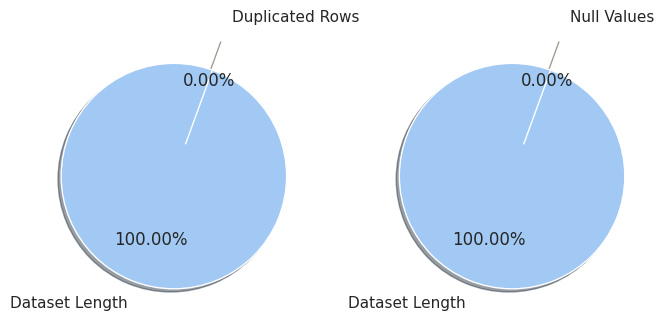

In [12]:
def null_and_dupes(data):
    fig, ax = plt.subplots(1, 2, figsize = (8, 10))
    n_dupes, n_null = data.duplicated().sum(), data.isnull().sum().sum()
    
    for idx, item in enumerate({'Duplicated Rows':n_dupes, \
                                'Null Values':n_null}.items()):
        explode = [0, 0.3]
        ax[idx].pie([len(data)-item[1], item[1]], 
                    labels = ['Dataset Length', item[0]], 
                    explode = explode, 
                    shadow = True,
                    startangle = 70,
                    labeldistance = 1.2,
                    autopct='%1.2f%%')
    plt.show()
    
null_and_dupes(train_data)

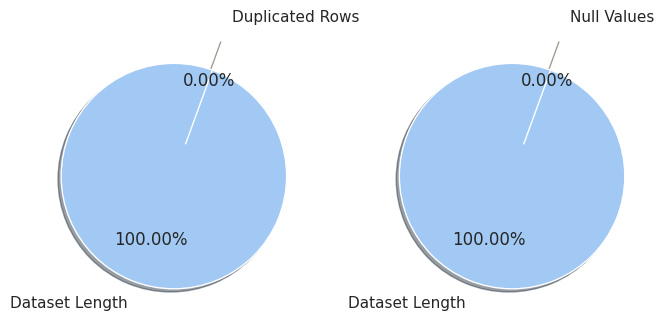

In [13]:
null_and_dupes(test_data)

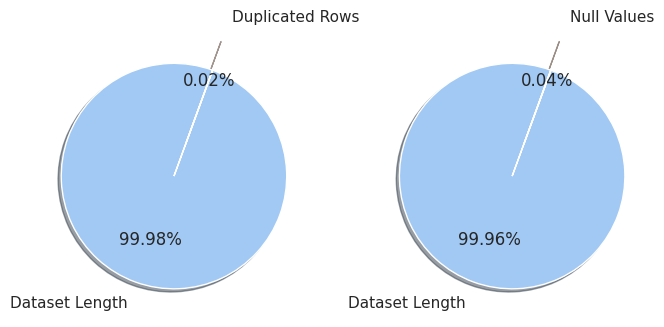

In [14]:
null_and_dupes(orig_data)

In [15]:
orig_data.drop_duplicates(inplace = True, keep = 'first')
orig_data.dropna(inplace = True)

<h3 style = 'font-family: Ebrima'>Target Analysis</h3> 

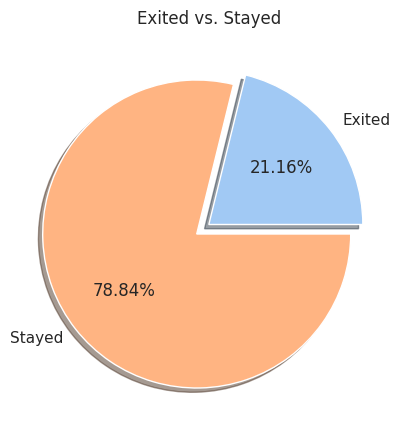

In [16]:
exit_stay = [len(train_data[train_data["Exited"] == 1]), len(train_data[train_data["Exited"] == 0])]
explode = [0.0, 0.1]

plt.figure(figsize = (5, 5))
plt.pie(exit_stay, labels = ['Exited', 'Stayed'], explode = explode, shadow = True, autopct='%1.2f%%')
plt.title('Exited vs. Stayed')
plt.show()

Text(0.5, 1.0, 'Customer Churn by Geography')

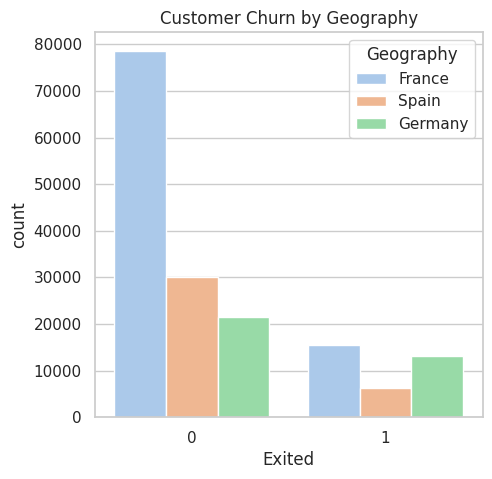

In [17]:
plt.figure(figsize = (5, 5))
sns.countplot(train_data, x = 'Exited', hue = 'Geography', palette = 'pastel')
plt.title('Customer Churn by Geography')

Text(0.5, 1.0, 'Customer Churn by Activity')

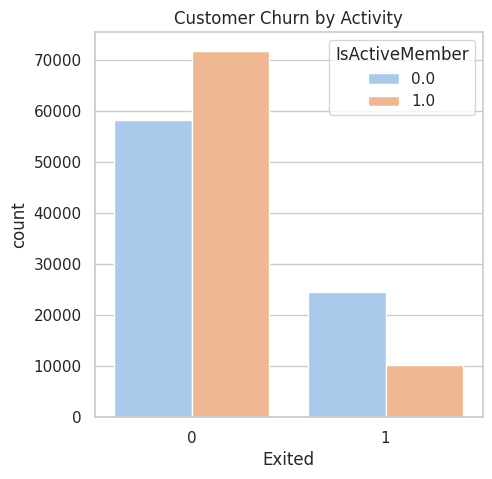

In [18]:
plt.figure(figsize = (5, 5))
sns.countplot(train_data, x = 'Exited', hue = 'IsActiveMember')
plt.title('Customer Churn by Activity')

Text(0.5, 1.0, 'Customer Churn by Gender')

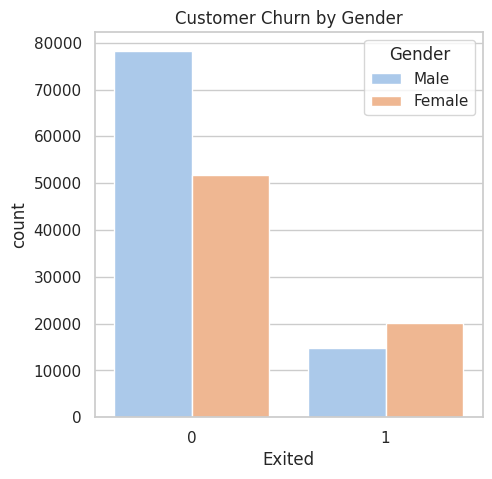

In [19]:
plt.figure(figsize = (5, 5))
sns.countplot(train_data, x = 'Exited', hue = 'Gender')
plt.title('Customer Churn by Gender')

In [20]:
# # Deal with duplicated rows
# train_data.drop_duplicates(inplace = True, keep = 'first')
# orig_data.drop_duplicates(inplace = True, keep = 'first')

# # Drop null values in original data
# orig_data.dropna(inplace = True)

In [21]:
cat_cols = ['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Tenure']

def cat_counts(data_1, data_2, columns, title = None, figsize = (10, 18)):
    nrows, ncols = len(columns), 2
    fig, ax = plt.subplots(nrows, ncols, figsize = figsize)
    
    datasets = {0:data_1, 1:data_2}
    
    for i in range(nrows):
        for j in range(ncols):
            sns.countplot(data = datasets[j], x = columns[i], ax = ax[i, j])
            ax[i, j].set_xlabel(columns[i])
    
    fig.suptitle(title)
    fig.tight_layout(rect = [0, 0.03, 1, 0.98])
    plt.show()

<div style = 'font-family: Ebrima'>
    <h2>_ Categorical Feature Distributions</h2>
</div>

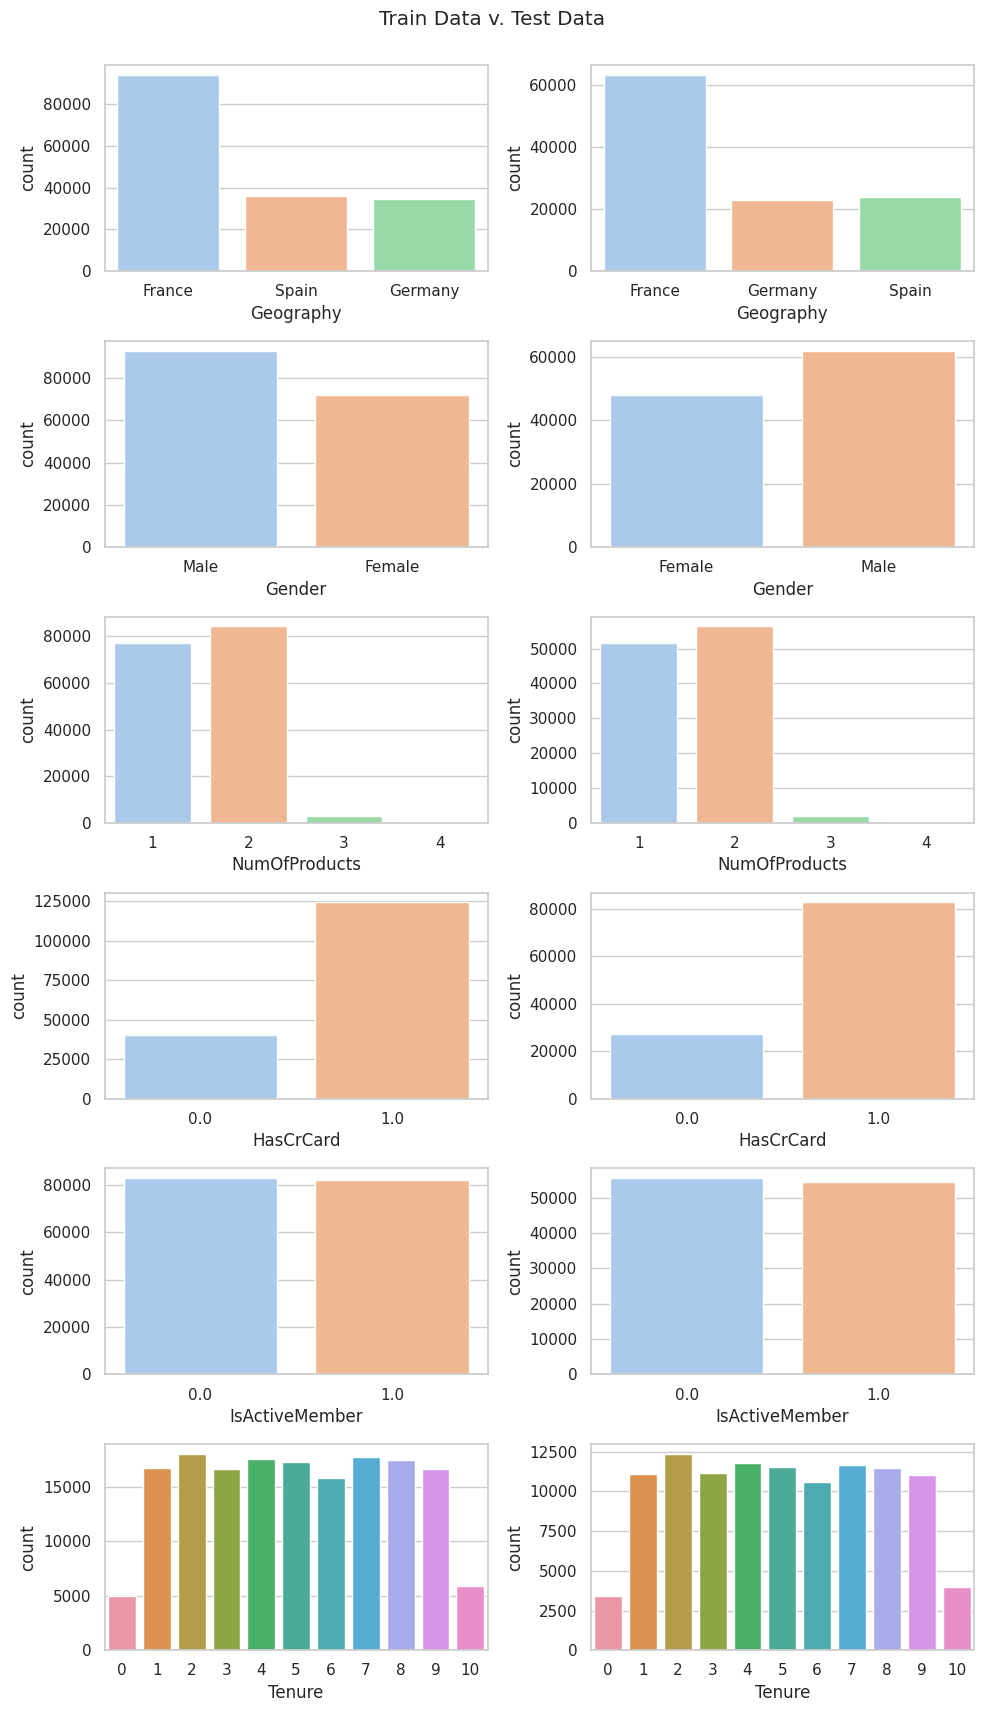

In [22]:
cat_counts(train_data, test_data, columns = cat_cols, title = 'Train Data v. Test Data')

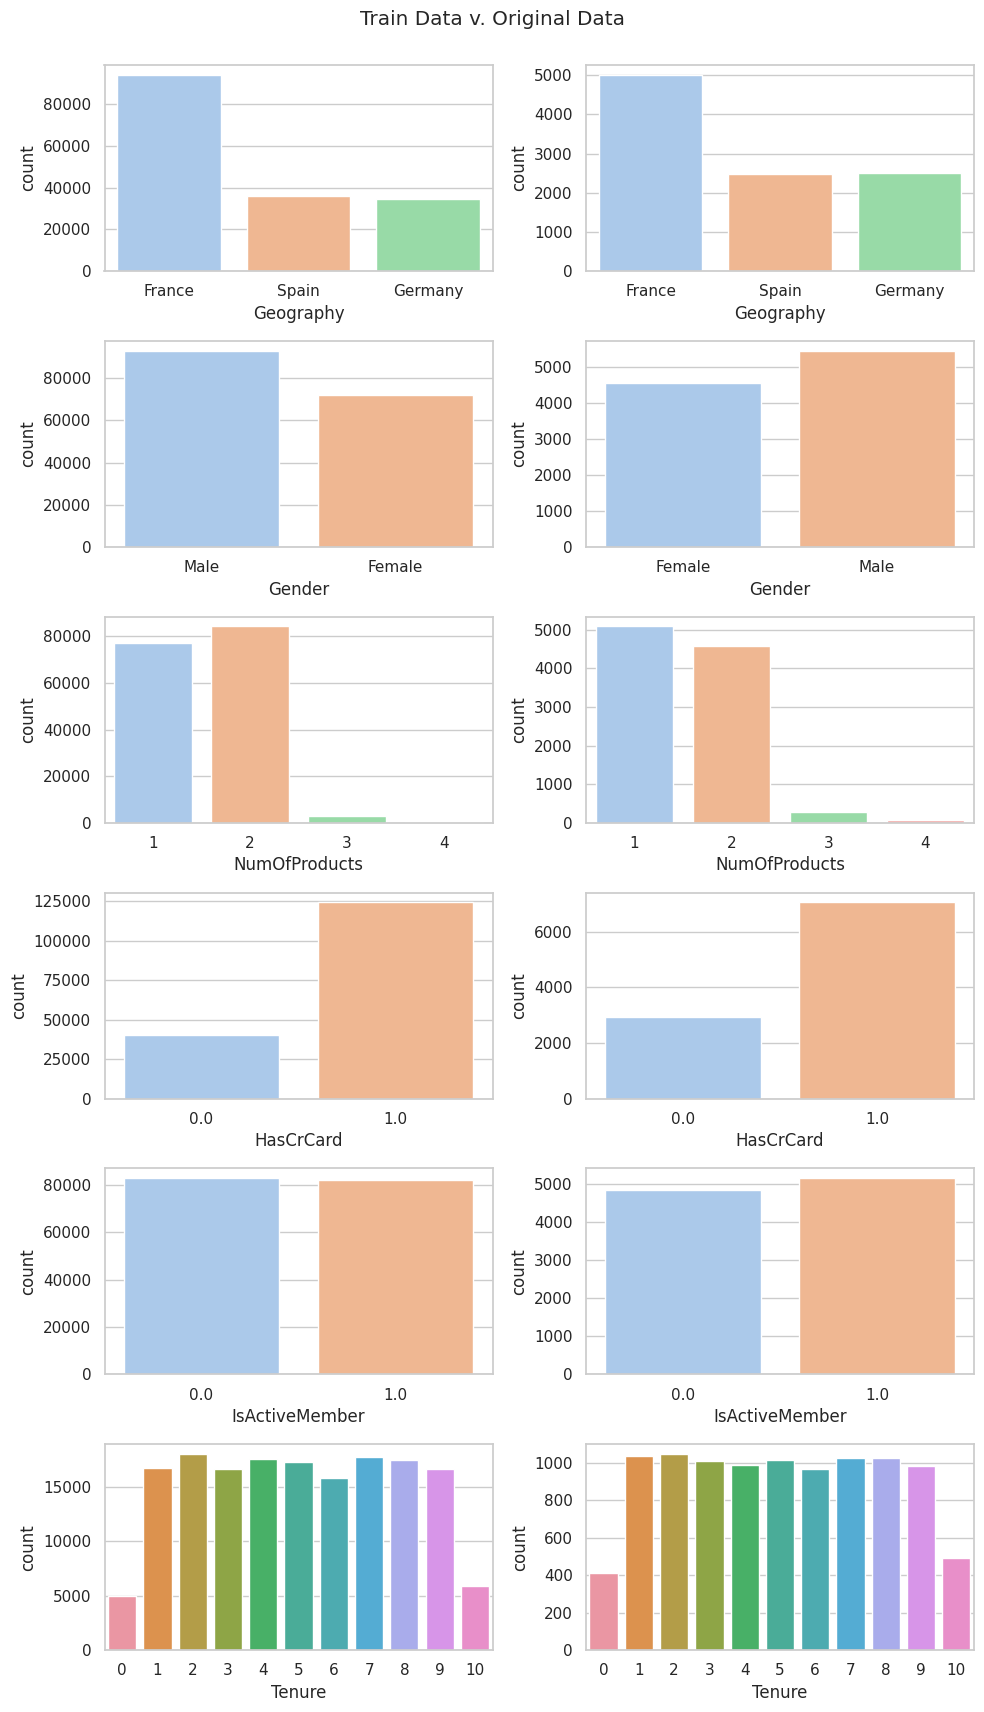

In [23]:
cat_counts(train_data, orig_data, columns = cat_cols, title = 'Train Data v. Original Data')

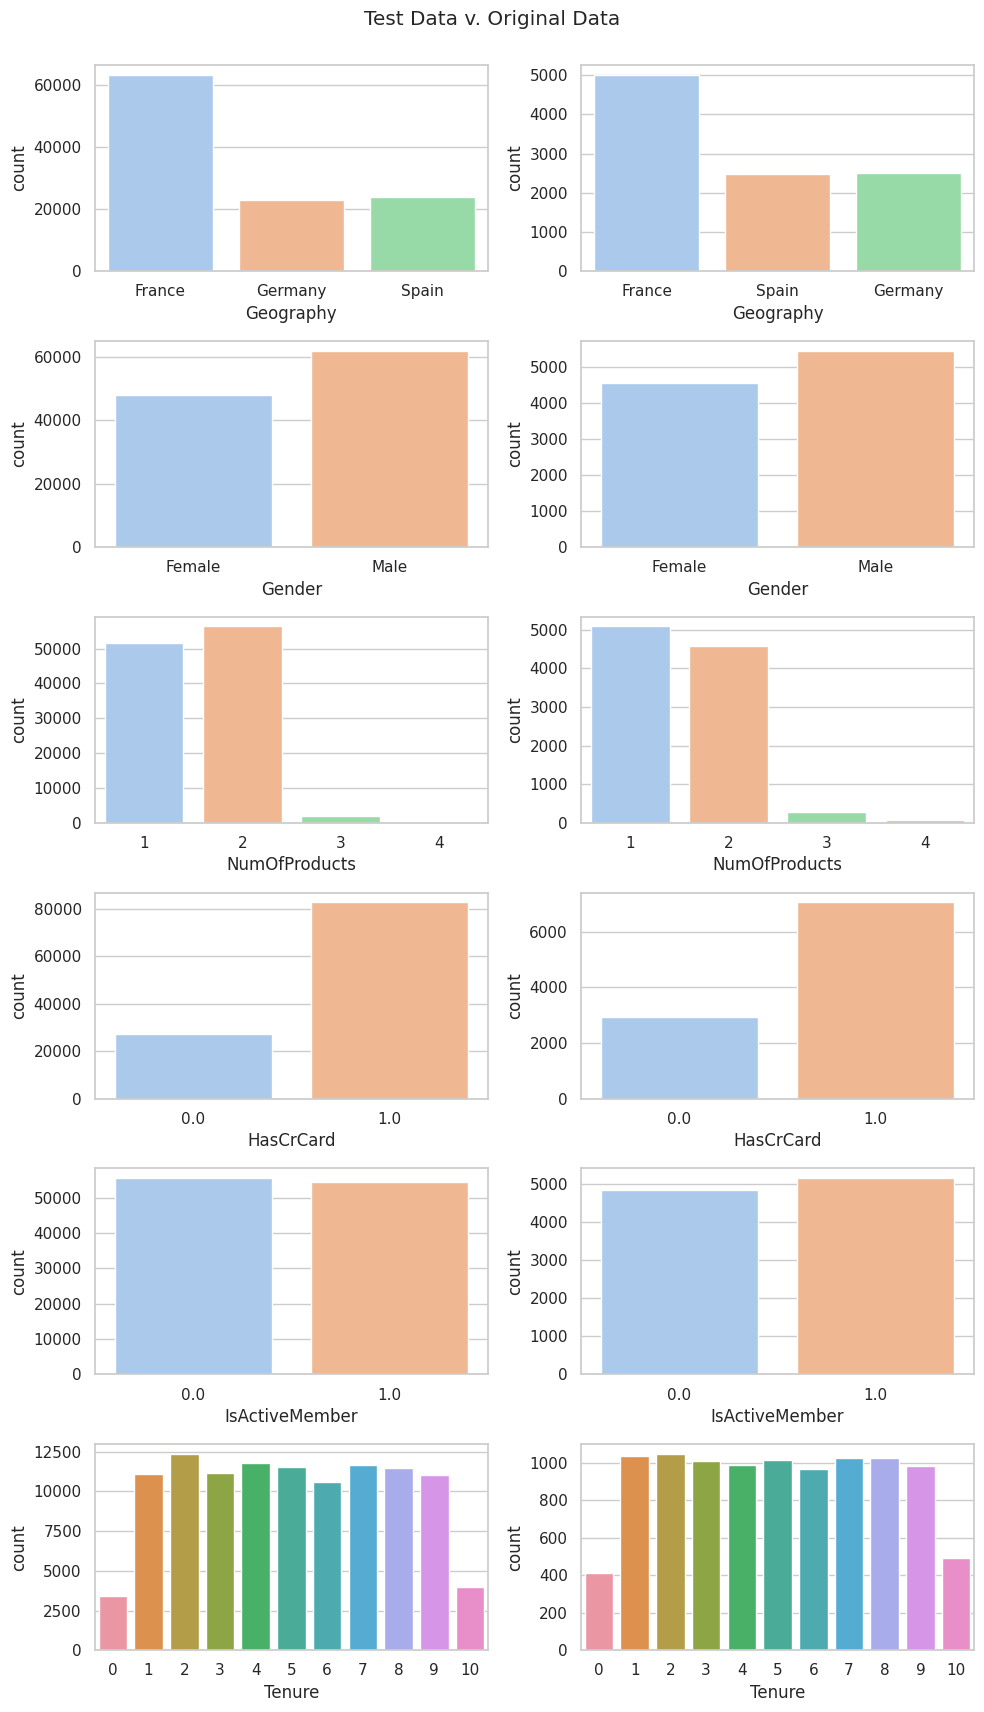

In [24]:
cat_counts(test_data, orig_data, columns = cat_cols, title = 'Test Data v. Original Data')

<div style = 'font-family: Ebrima'>
    <h2>_ Numerical Feature Distributions</h2>
</div>

In [25]:
num_cols = train_data[[col for col in train_data.columns if col not in cat_cols][:-1]].columns.to_list()

def hist_box_plots(data, columns, bins = 25, kde = True, figsize= (15, 10)):
    data = data[columns]
    nrows, ncols = len(data.columns), 2
    fig, ax = plt.subplots(nrows, ncols, figsize = figsize)
    
    for idx, col in enumerate(data.columns):
        plt.subplot(nrows, ncols, ncols*idx+1)
        sns.histplot(data, x = col, bins = bins, kde = kde)
        
        plt.subplot(nrows, ncols, ncols*idx+2)
        sns.boxplot(data, x = col, orient = 'h')
    
    fig.tight_layout()
    plt.show()

In [26]:
num_cols.remove('Surname')

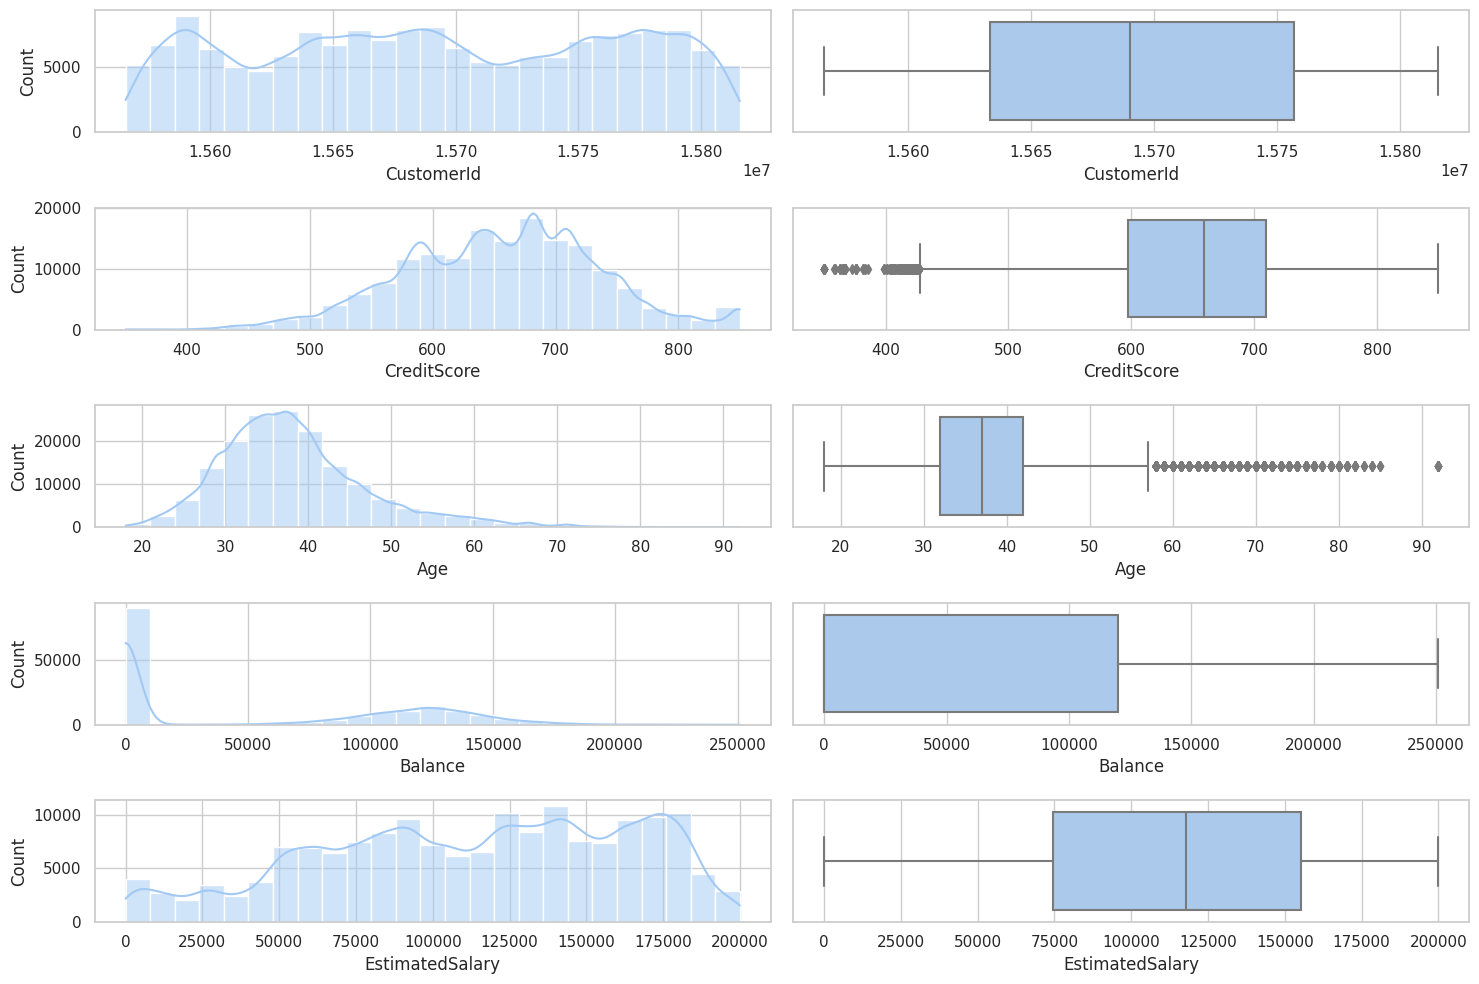

In [27]:
hist_box_plots(train_data, num_cols)

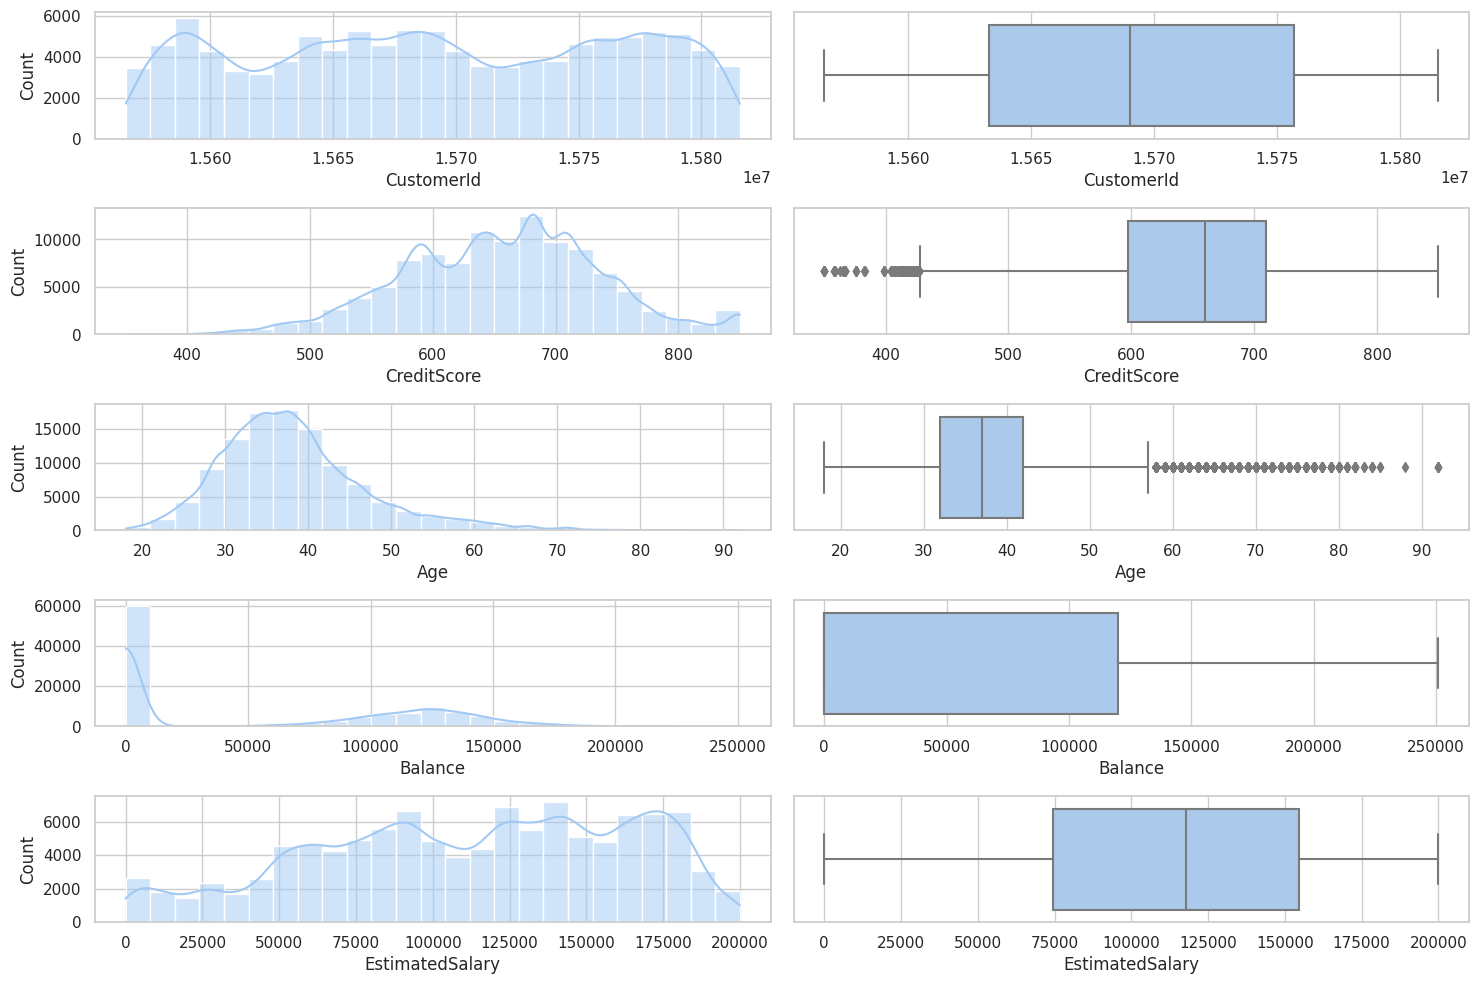

In [28]:
hist_box_plots(test_data, num_cols)

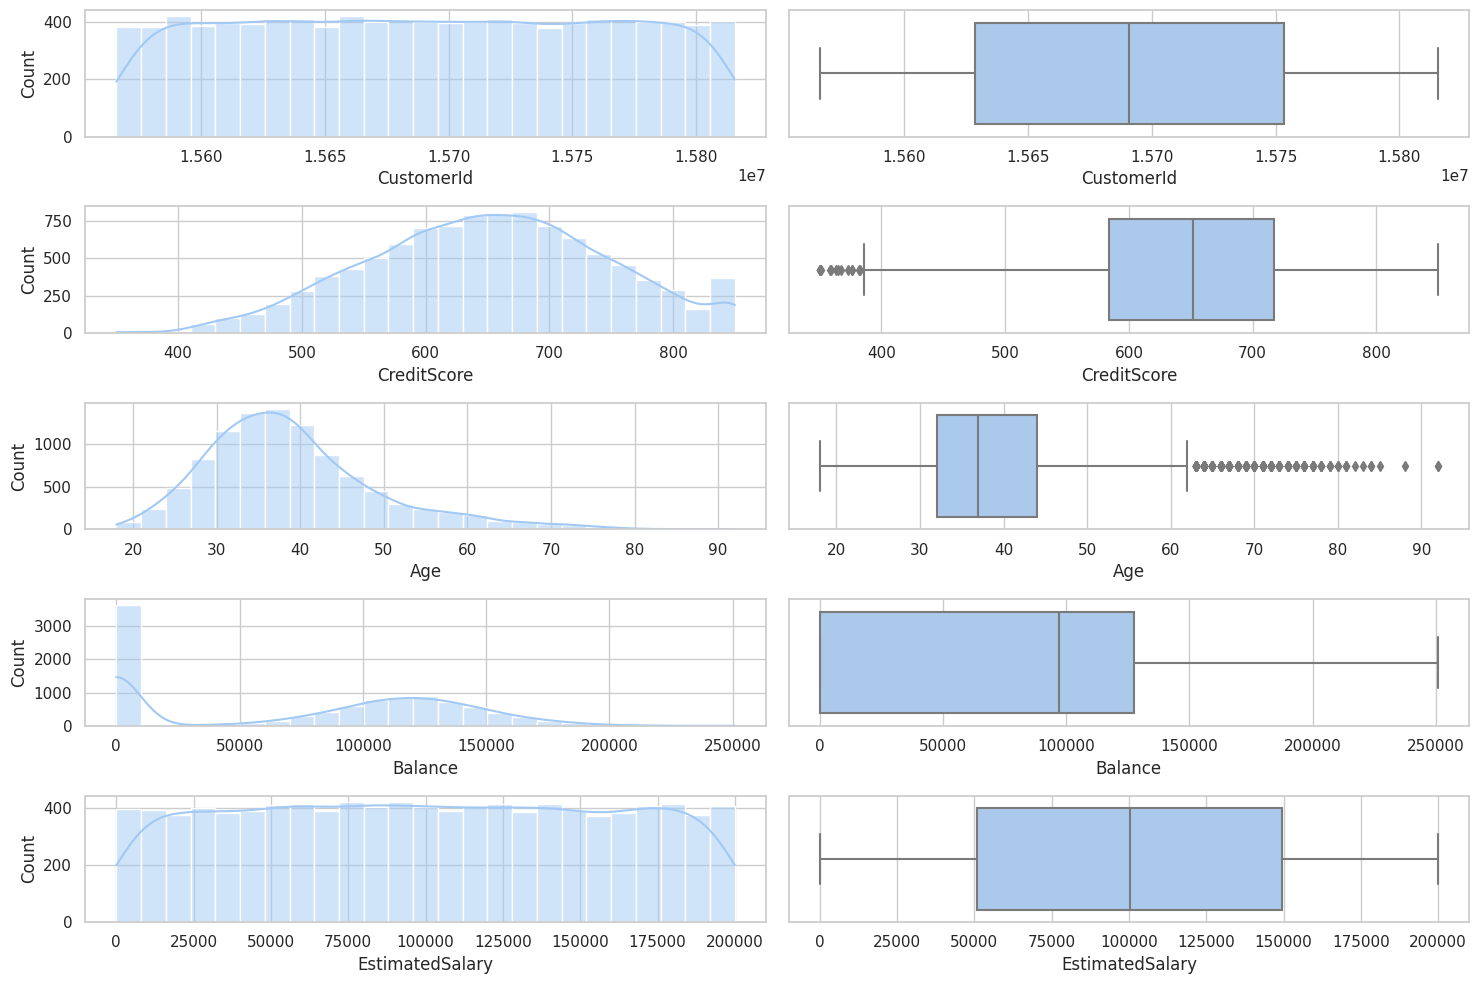

In [29]:
hist_box_plots(orig_data, num_cols)

<div style = 'font-family: Ebrima'>
    <h2>_ Check Skewness</h2>
</div>

In [30]:
from scipy.stats import skew

for dataset in {'Train Data':train_data, 'Test Data':test_data, 'Original Data':orig_data}.items():
    print(f'\n{dataset[0]}')
    print('-'*15)
    for col in num_cols:
        print(f'\n[{col}] Skewness: {skew(dataset[1][col], nan_policy = "omit")}')
    print('\n')


Train Data
---------------

[CustomerId] Skewness: -0.022939624822732745

[CreditScore] Skewness: -0.059290680776909584

[Age] Skewness: 0.9680539938699673

[Balance] Skewness: 0.3820169761980373

[EstimatedSalary] Skewness: -0.309018731016704



Test Data
---------------

[CustomerId] Skewness: -0.02414896062108537

[CreditScore] Skewness: -0.062400121167679776

[Age] Skewness: 0.9723902892008612

[Balance] Skewness: 0.38521322404329

[EstimatedSalary] Skewness: -0.30528716484567975



Original Data
---------------

[CustomerId] Skewness: 0.0011523103683198487

[CreditScore] Skewness: -0.07196928267108843

[Age] Skewness: 1.011623044536122

[Balance] Skewness: -0.1407442920619671

[EstimatedSalary] Skewness: 0.0016358765693810634




In [31]:
# Merge playground dataset with original dataset
train_data = pd.concat([train_data, orig_data]).reset_index(drop = True)
train_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [32]:
train_copy = train_data.copy()
test_copy = test_data.copy()

label_enc = LabelEncoder()

train_copy['Surname'] = label_enc.fit_transform(train_data['Surname'])
test_copy['Surname'] = label_enc.transform(test_data[['Surname']])

train_copy['Gender'] = label_enc.fit_transform(train_data['Gender'])
test_copy['Gender'] = label_enc.transform(test_data['Gender'])

train_copy['Geography'] = label_enc.fit_transform(train_data['Geography'])
test_copy['Geography'] = label_enc.transform(test_data['Geography'])

n_clusters = 5
Kmeans = KMeans(n_clusters = n_clusters, n_init = 'auto', random_state = 42)

train_data['Clusters'] = Kmeans.fit_predict(train_copy.drop('Exited', axis = 1))
test_data['Clusters'] = Kmeans.predict(test_copy)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [33]:
def plot_correlations(corr, target, title = None, cmap = 'Greens', figsize = (15, 10)):
    fig, ax = plt.subplots(1, 2, figsize = figsize)
    
    mask = np.tril(np.ones_like(corr, dtype = bool))
    sns.heatmap(corr, cmap = cmap, annot = True, fmt = '.3f', square = True, mask = mask, ax = ax[0], annot_kws = {'size':8}, cbar = False)
    
    lin_corr = corr[target].sort_values(ascending = False).to_frame()
    sns.heatmap(lin_corr, cmap = cmap, annot = True, fmt = '.4f', ax = ax[1])
    
    if title is not None:
        fig.suptitle(title, size = 15)
    
    fig.tight_layout(rect = [0, 0.03, 1, 0.95])
    plt.show()

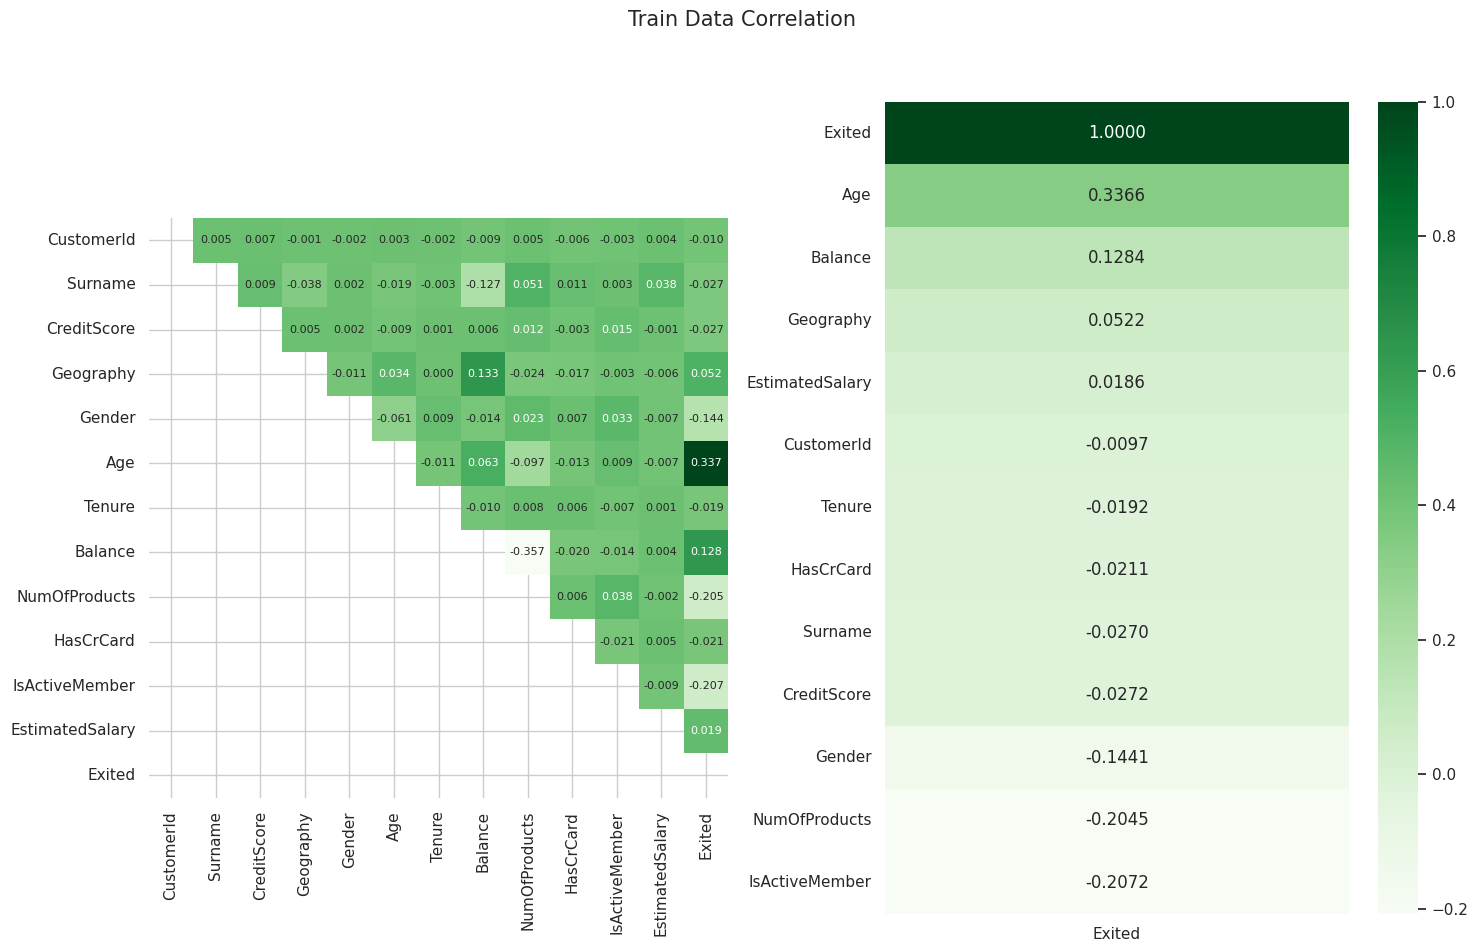

In [34]:
plot_correlations(train_copy.corr(), target = 'Exited', title = 'Train Data Correlation')

<div style = 'font-family: Ebrima'>
    <h2>_ Feature Engineering</h2>

</div>

In [35]:
train_data.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Clusters
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,1
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,4
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,1
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,4


In [36]:
train_data.tail()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Clusters
175025,15606229,Obijiaku,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0,1
175026,15569892,Johnstone,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0,1
175027,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1,1
175028,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1,3
175029,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0,3


In [37]:
from sklearn.feature_extraction.text import CountVectorizer

def tf_idf(train, test, column, n, p):
    vectorizer = TfidfVectorizer(max_features=n)
    vectors_train = vectorizer.fit_transform(train[column])
    vectors_test = vectorizer.transform(test[column])
    
    svd = TruncatedSVD(p)
    x_pca_train = svd.fit_transform(vectors_train)
    x_pca_test = svd.transform(vectors_test)
    tfidf_df_train = pd.DataFrame(x_pca_train)
    tfidf_df_test = pd.DataFrame(x_pca_test)

    
    cols = [(column+"_tfidf_"+str(f)) for f in tfidf_df_train.columns]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols
    train = pd.concat([train,tfidf_df_train], axis='columns')
    test = pd.concat([test,tfidf_df_test], axis='columns')
    
    return train, test

def count_vowels(surname):
    return sum(1 for char in surname if char.lower() in 'aeiou')

def count_consonants(surname):
    return sum(1 for char in surname if char.isalpha() and char.lower() not in 'aeiou')

def feature_engineer(data, target = None):
    
    if target is not None:
        target_col = data[target]
        data = data.drop(target, axis = 1)
    
    data_copy = data.copy()
    
    data_copy['Customer_Frequency'] = data.groupby('CustomerId')['CustomerId'].transform('count')
    data_copy['Average_Balance_per_Customer'] = data.groupby('CustomerId')['Balance'].transform('mean')
    data_copy['Total_Balance_per_Customer'] = data.groupby('CustomerId')['Balance'].transform('sum')
    data_copy['Customer_Tenure'] = data.groupby('CustomerId')['Tenure'].transform('max')
    data_copy['CustomerId_FirstThreeDigits'] = data['CustomerId'].apply(lambda x: int(str(x)[:3]))
    
    data_copy['Geography'] = (data['Geography']).astype('category')
    data_copy['Gender'] = (data['Gender']).astype('category')
    
    data_copy['Balance_Salary_Ratio'] = data['Balance'] / data['EstimatedSalary']
    data_copy['Zero_Balance'] = (data['Balance'] == 0).astype('category')
    data_copy['TotalProducts'] = data['NumOfProducts'] + data['HasCrCard']
    
    data_copy['Surname_Length'] = data['Surname'].apply(lambda x: len(x))
    data_copy['Num_Vowels'] = data['Surname'].apply(count_vowels)
    data_copy['Num_Consonants'] = data['Surname'].apply(count_consonants)
    
    data_copy['First_Letter'] = (data['Surname'].str[0]).astype('category')
    data_copy['First_Two_Letters'] = (data['Surname'].str[:2]).astype('category')
    data_copy['Last_Letter'] = (data['Surname'].str[-1]).astype('category')
    data_copy['Last_Two_Letters'] = (data['Surname'].str[-2:]).astype('category')
    
    data_copy['HasCrCard'] = data['HasCrCard'].astype('category')
    data_copy['IsActiveMember'] = data['IsActiveMember'].astype('category')
    
    surname_counts = data['Surname'].value_counts()
    data_copy['Surname_Frequency'] = data['Surname'].map(surname_counts)
    
    data_copy['Age_Group'] = pd.cut(data['Age'], bins = [18, 30, 40, 50, 60, 100], labels = ['18-30', '30-40', '40-50', '50-60', '60+'],\
                                    include_lowest = True).astype('category')
    data_copy['HasCrCard_And_ActiveMember'] = (data['HasCrCard'] + data['IsActiveMember'])
    
    data_copy['AgeAtAccountCreation'] = data['Age'] - data['Tenure']
    data_copy['CreditScore_Category'] = pd.cut(data['CreditScore'], bins = [300, 600, 700, 800, 900], \
                                               labels = ['300-600', '600-700', '700-800', '900+'])
    
    data_copy['NProduct_ActiveMember'] = (data_copy['TotalProducts'] * data['IsActiveMember']).astype(int)
    data_copy['BalancePerProduct'] = data['Balance'] / data_copy['TotalProducts']
    data_copy['Age*Product'] = data['Age'] * data_copy['TotalProducts']
    data_copy['Age/Product'] = data['Age'] / data_copy['TotalProducts']
    data_copy['Geography_Gender'] = (data['Geography'] + '_' + data['Gender']).astype('category')
    
    if target is not None:
        data_copy[target] = (target_col).astype('category')
    return data_copy

In [38]:
train_fe = feature_engineer(data = train_data, target = 'Exited')
train_fe.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,Age_Group,HasCrCard_And_ActiveMember,AgeAtAccountCreation,CreditScore_Category,NProduct_ActiveMember,BalancePerProduct,Age*Product,Age/Product,Geography_Gender,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,...,30-40,1.0,30.0,600-700,0,0.00,99.0,11.000000,France_Male,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,...,30-40,2.0,32.0,600-700,3,0.00,99.0,11.000000,France_Male,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,...,30-40,1.0,30.0,600-700,0,0.00,120.0,13.333333,France_Male,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,...,30-40,2.0,32.0,300-600,2,74441.27,68.0,17.000000,France_Male,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,...,30-40,2.0,28.0,700-800,3,0.00,99.0,11.000000,Spain_Male,0


In [39]:
test_fe = feature_engineer(data = test_data)
test_fe.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,...,Surname_Frequency,Age_Group,HasCrCard_And_ActiveMember,AgeAtAccountCreation,CreditScore_Category,NProduct_ActiveMember,BalancePerProduct,Age*Product,Age/Product,Geography_Gender
0,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,...,403,18-30,1.0,21.0,300-600,2,0.00,46.0,11.500000,France_Female
1,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,...,19,40-50,1.0,44.0,600-700,0,0.00,92.0,23.000000,France_Female
2,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,...,452,30-40,1.0,27.0,600-700,0,0.00,102.0,11.333333,France_Female
3,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,...,301,30-40,1.0,28.0,600-700,0,0.00,72.0,18.000000,France_Male
4,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,...,5,30-40,1.0,28.0,700-800,0,60631.81,76.0,19.000000,Germany_Male


In [40]:
train_fe, test_fe = tf_idf(train_fe, test_fe, 'Surname', 1000, 5)

train_fe['Surname'] = train_copy['Surname']
test_fe['Surname'] = test_copy['Surname']

<h1 style = 'font-family: Ebrima'>// ~ Modelling</h1>
<hr>

<h3 style = 'font-family: Ebrima'>_Feature Selection</h3>

In [41]:
cat_cols = train_fe.select_dtypes(include = 'category').columns.to_list()[:-1]
num_cols = train_fe.select_dtypes(exclude = 'category').columns.to_list()

Text(0.5, 1.0, 'Numerical Features Mutual Information Scores')

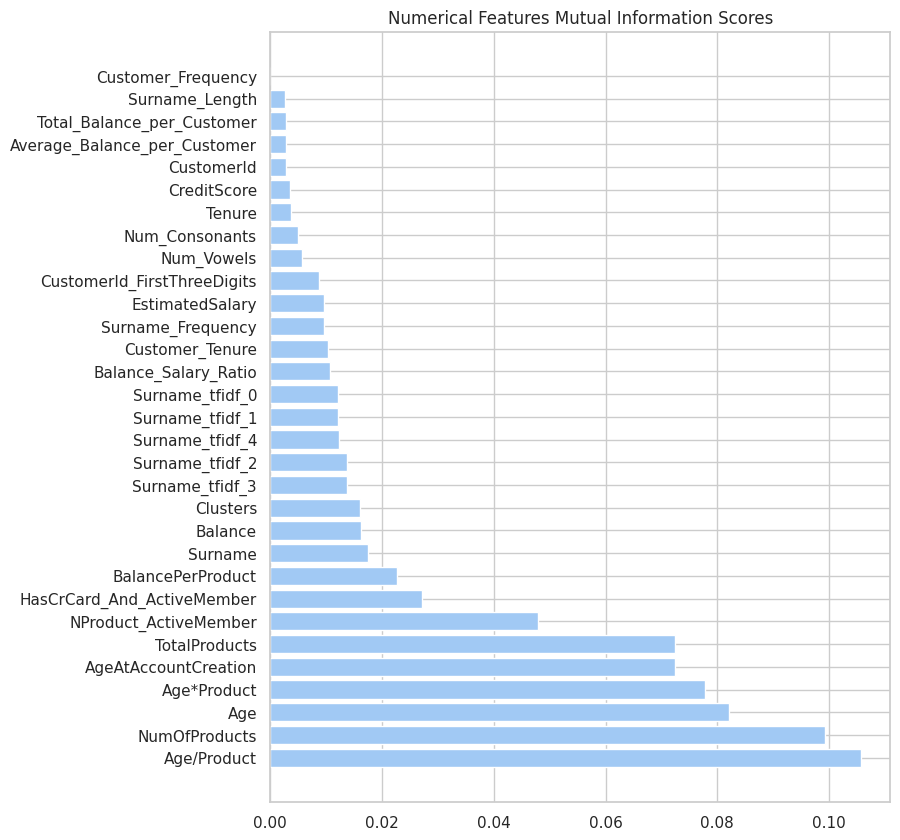

In [42]:
from sklearn.feature_selection import mutual_info_classif
scores, features = [], []
high_score_feats = []

feature_scores = mutual_info_classif(train_fe[num_cols], train_fe['Exited'], random_state = 42)
for score, name in sorted(zip(feature_scores, train_fe[num_cols].columns), reverse = True):
    scores.append(score)
    features.append(name)
    
    if score > 0.01:
        high_score_feats.append(name)
    
plt.figure(figsize = (8, 10))
plt.barh(features, scores)
plt.title('Numerical Features Mutual Information Scores')

In [43]:
train_fe.drop([col for col in num_cols if col not in high_score_feats], axis = 1, inplace = True)
train_fe.head()

,Surname,Geography,Gender,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,Clusters,Customer_Tenure,...,BalancePerProduct,Age*Product,Age/Product,Geography_Gender,Exited,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Surname_tfidf_3,Surname_tfidf_4
0,2023,France,Male,33.0,0.00,2,1.0,0.0,1,10,...,0.00,99.0,11.000000,France_Male,0,1.945235e-07,2.444422e-07,9.188325e-08,-5.773452e-06,0.000006
1,2024,France,Male,33.0,0.00,2,1.0,1.0,4,9,...,0.00,99.0,11.000000,France_Male,0,-2.634461e-07,-5.331395e-07,5.116226e-07,-7.041645e-06,0.000016
2,1236,France,Male,40.0,0.00,2,1.0,0.0,1,10,...,0.00,120.0,13.333333,France_Male,0,-6.275828e-04,3.172952e-03,5.691344e-04,1.731435e-02,-0.005481
3,1362,France,Male,34.0,148882.54,1,1.0,1.0,0,10,...,74441.27,68.0,17.000000,France_Male,0,-4.234212e-05,-6.571374e-04,3.714743e-04,4.384693e-03,-0.009163
4,491,Spain,Male,33.0,0.00,2,1.0,1.0,4,10,...,0.00,99.0,11.000000,Spain_Male,0,-2.517092e-08,-1.016457e-07,-6.117352e-07,-9.233175e-07,0.000007


In [44]:
# Set random seed for reproducibility
random_seed = 42

# Create column transformer
ct = make_column_transformer((OneHotEncoder(), cat_cols), # exclude target column `Exited`
                             (PowerTransformer(), high_score_feats))

# Set features and labels
X = train_fe.drop('Exited', axis = 1)
y = np.array(train_fe['Exited'])

# Transform feature columns
X = ct.fit_transform(X).toarray()

X.shape, y.shape

((175030, 601), (175030,))

In [45]:
test_trans = ct.transform(test_fe).toarray()
test_trans.shape

(110023, 601)

<div style = 'font-family: Ebrima'>
    <h2>Hyperparameter Tuning with Optuna</h2>
</div>

In [46]:
import optuna

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = random_seed)

def lgbm_objective(trial):
    params = {
       'boosting_type' : trial.suggest_categorical('boosting_type', ['gbdt']),
       'max_depth': trial.suggest_int('max_depth', 7, 15),
       'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log = True),
       'n_estimators': trial.suggest_int('n_estimators', 500, 1000),
       'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
       'subsample': trial.suggest_float('subsample', 0.01, 1.0, log = True),
       'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log = True),
       'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 1.0, log = True),
       'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 1.0, log = True),
   }
    
    model = LGBMClassifier(**params, verbosity = -1)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    return roc_auc_score(y_test, y_prob[:, 1])

def xgb_objective(trial):        
    params = {
        'lambda': trial.suggest_float('lambda', 1e-4, 10.0, log = True),
        'alpha': trial.suggest_float('alpha', 1e-4, 10.0, log = True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.5, 0.7, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008, 0.01, 0.02, 0.05]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 400, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15, 17, 20]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_float('gamma', 1e-4, 10.0, log = True),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 100.0)
    }
    
    model = XGBClassifier(**params)    
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    return roc_auc_score(y_test, y_prob[:, 1])

def hgb_objective(trial):
    params = {
        'l2_regularization': trial.suggest_float('l2_regularization',1e-3,10.0, log = True),
        'learning_rate': trial.suggest_float('learning_rate', 0.001,0.1, log = True),
        'max_iter': trial.suggest_categorical('max_iter', [1000]),
        'max_depth': trial.suggest_int('max_depth', 2,30),
        'max_bins': trial.suggest_int('max_bins', 100,255),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20,1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 20,80),
    }

    model = HistGradientBoostingClassifier(**params)
    model.fit(X_train, y_train)
    y_prob = model.predict_proba(X_test)
    
    return roc_auc_score(y_test, y_prob[:, 1])

In [47]:
# study = optuna.create_study(direction = 'maximize', 
#                             pruner = optuna.pruners.HyperbandPruner(min_resource = 1, max_resource = 100, reduction_factor = 3))
# study.optimize(hgb_objective, n_trials = 30)
# study.best_params

In [48]:
lgbm_params = {'boosting_type': 'gbdt',
 'max_depth': 11,
 'learning_rate': 0.03489412695476153,
 'n_estimators': 917,
 'min_child_weight': 3,
 'subsample': 0.011061908674683586,
 'colsample_bytree': 0.2301046953275732,
 'reg_alpha': 0.046422452587343906,
 'reg_lambda': 0.16087624319191646}

xgb_params = {'lambda': 0.0005070513289981429, 
              'alpha': 0.13786512248427832, 
              'colsample_bytree': 1.0, 
              'subsample': 0.6, 
              'learning_rate': 0.05, 
              'n_estimators': 100, 
              'max_depth': 17, 
              'min_child_weight': 199, 
              'gamma': 0.0014891059843182392, 
              'scale_pos_weight': 41.93848570220008}

# hgb_params = {'l2_regularization': 0.1922563039802614, 
#               'learning_rate': 0.004976589051808292, 
#               'max_iter': 1000, 
#               'max_depth': 13, 
#               'max_bins': 120, 
#               'min_samples_leaf': 143, 
#               'max_leaf_nodes': 67}

In [49]:
models = [('LogisticRegression', LogisticRegression(max_iter = 1000)),
          ('CatBoostClassifier', CatBoostClassifier(verbose = False)),
          ('LGBMClassifier', LGBMClassifier(**lgbm_params, verbosity = -1)),
          ('XGBClassifier', XGBClassifier(**xgb_params))]

metric_fns = [('ROC AUC', roc_auc_score),
              ('Log Loss', log_loss)]

In [50]:
def calculate_metrics(y_test, y_pred, metric_fns):
    # Dictionary to store the score for each metric
    results = {}
    
    # Loop through each metric 
    for metric_fn in metric_fns:
        # Calculate score using metric
        score = metric_fn[1](y_test, y_pred)
        
        # Store score as value and metric as key
        results[metric_fn[0]] = score
        
        # Display metric score
        print(f'{metric_fn[0]} : {score:.5f}')
    return results

def cross_validate(models, X, y, cv_method, n_splits = 5, metric_fns = None, shuffle = True, random_seed = None):
    # Dictionaries to store out-of-fold predictions and out-of-fold metric scores
    oof_preds, oof_metrics = {}, {}
    x_data, y_data = [], []
    
    cv = cv_method(n_splits = n_splits, shuffle = shuffle, random_state = random_seed)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        print(f'Fold #{idx+1}')
        print('-'*40+'\n')
        
        x_train, x_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        x_data.extend(x_test)
        y_data.extend(y_test)
        
        for model in models:
            print(f'Cross-validating: [{model[0]}]\n')
            
            if model[0] not in oof_preds:
                oof_preds[model[0]] = []
                oof_metrics[model[0]] = {}
                
            model[1].fit(x_train, y_train)
            y_pred = model[1].predict_proba(x_test)
            
            # Save model predictions
            oof_preds[model[0]].append(y_pred)
            
            # Calculate metrics
            for metric_name, result in calculate_metrics(y_test, y_pred[:, 1], metric_fns).items():
                
                # Save metric result if not already in dictionary
                if metric_name not in oof_metrics[model[0]]:
                    oof_metrics[model[0]][metric_name] = []
                oof_metrics[model[0]][metric_name].append(result)
            print('\n')
    
    return oof_preds, oof_metrics, (x_data, y_data)
            

In [51]:
oof_preds, oof_metrics, data = cross_validate(models, X, y, StratifiedKFold, metric_fns = metric_fns, random_seed = random_seed)

Fold #1
----------------------------------------

Cross-validating: [LogisticRegression]

ROC AUC : 0.88045
Log Loss : 0.33155


Cross-validating: [CatBoostClassifier]

ROC AUC : 0.89276
Log Loss : 0.31417


Cross-validating: [LGBMClassifier]

ROC AUC : 0.89392
Log Loss : 0.31262


Cross-validating: [XGBClassifier]

ROC AUC : 0.89037
Log Loss : 1.09336


Fold #2
----------------------------------------

Cross-validating: [LogisticRegression]

ROC AUC : 0.87958
Log Loss : 0.33529


Cross-validating: [CatBoostClassifier]

ROC AUC : 0.89183
Log Loss : 0.31588


Cross-validating: [LGBMClassifier]

ROC AUC : 0.89280
Log Loss : 0.31459


Cross-validating: [XGBClassifier]

ROC AUC : 0.88965
Log Loss : 1.09540


Fold #3
----------------------------------------

Cross-validating: [LogisticRegression]

ROC AUC : 0.87951
Log Loss : 0.33361


Cross-validating: [CatBoostClassifier]

ROC AUC : 0.89138
Log Loss : 0.31678


Cross-validating: [LGBMClassifier]

ROC AUC : 0.89234
Log Loss : 0.31512


Cro

In [52]:
def get_oof_metrics(metric_dict):
    dict, df = {'models': []}, pd.DataFrame()
    
    for model in list(metric_dict.keys()):
        dict['models'].append(model)
        for metric in list(metric_dict[model].keys()):
            if metric not in dict:
                dict[metric] = []
            dict[metric].append(np.mean(metric_dict[model][metric]))
            
    df.index = dict['models']
    for metric in list(dict.keys())[1:]:
        df[metric] = dict[metric]
    
    return df

In [53]:
oof_metrics_df = get_oof_metrics(oof_metrics)
oof_metrics_df.sort_values(by = 'ROC AUC', ascending = False)

,ROC AUC,Log Loss
LGBMClassifier,0.893348,0.313691
CatBoostClassifier,0.892356,0.315067
XGBClassifier,0.890206,1.092894
LogisticRegression,0.879692,0.333102


In [54]:
oof_metrics_df.sort_values(by = 'Log Loss', ascending = True)

,ROC AUC,Log Loss
LGBMClassifier,0.893348,0.313691
CatBoostClassifier,0.892356,0.315067
LogisticRegression,0.879692,0.333102
XGBClassifier,0.890206,1.092894


<div style = 'font-family: Ebrima'>
    <h2>Adaptive Weight Training with Weighted Ensemble</h2>
</div>

In [55]:
class WeightedEnsemble:
    def __init__(self, models, weights = None, metric_fn = None, random_state = None):
        np.random.seed(random_state)
        
        self.random_state = random_state
        self.metric_fn = metric_fn
        self.models = models
        self.weights = np.random.sample(size = (len(models), 1)) if weights is None else np.array(weights).reshape(-1, 1)
        
    def adaptive_weight_train(self, X, y, cv_method, n_splits = 5, shuffle = True, pred_probs = False):
        cv = cv_method(n_splits = n_splits, shuffle = shuffle, random_state = self.random_state)
        avg_weight = 0
        
        print(f'Starting Adaptive Weight Training...\n')
        for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            print(f'Fold: #{idx+1}')
            print('-'*40+'\n')
            
            # Initialize with equal weights at the start of training
            self.weights = np.ones(shape = (len(self.models), 1)) if idx == 0 else self.weights
            
            x_train, x_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            self.fit(x_train, y_train)
            init_pred, weights = self.predict_proba(x_test, target = y_test) if pred_probs else self.predict(x_test, target = y_test)
            
            # Normalize weights
            norm_weights = [weight / sum(weights) for weight  in weights]
            
            self.weights = np.array(norm_weights).reshape(-1, 1)
            avg_weight += self.weights
            
            y_pred = self.predict_proba(x_test, target = None)
            
            print(f'Adapted Weights:\n\n{self.weights}\n')
            print(f'Metric Score: {self.metric_fn(y_test, y_pred[:, 1] if pred_probs else y_pred):.5f}\n')
        
        avg_weight /= n_splits
        print(f'Average Weight:\n\n{avg_weight}')
        self.weights = avg_weight
        
    def fit(self, X, y, sample_weight = None):
        fitted = []
        for model in self.models:
            if sample_weight is None:
                model.fit(X, y)
            else: 
                model.fit(X, y, sample_weight = sample_weight)
            fitted.append(model)
        self.models = fitted
    
    def predict(self, X, target = None):
        weights, preds = [], np.zeros(shape = (len(self.models), len(X)))
        
        for idx, model in enumerate(self.models):
            preds[idx] = model.predict(X) * self.weights[idx]
            if target is not None:
                weights.append(self.metric_fn(target, preds[idx]))
            
        final_preds = (np.sum(preds, axis = 0) / np.sum(self.weights)).astype(int)
        if target is None:
            return final_preds
        else:
            return final_preds, weights
    
    def predict_proba(self, X, target = None):
        weights, weighted_probs = [], np.zeros(shape = (len(self.models), len(X), len(np.unique(y))))
        
        for idx, model in enumerate(self.models):
            weighted_probs[idx] = model.predict_proba(X) * self.weights[idx]
            if target is not None:
                weights.append(self.metric_fn(target, weighted_probs[idx][:, 1]))
            
        final_probs = np.sum(weighted_probs, axis=0) / np.sum(self.weights)
        
        if target is None:
            return final_probs
        else:
            return final_probs, weights

In [56]:
top_models = [('LGBMClassifier', LGBMClassifier(**lgbm_params, verbosity = -1)),
              ('CatBoostClassifier', CatBoostClassifier(verbose = False))]

we = WeightedEnsemble([models[1] for models in top_models], metric_fn = roc_auc_score, random_state = random_seed)

In [57]:
we.adaptive_weight_train(X, y, cv_method = StratifiedKFold, n_splits = 10, pred_probs = True)

Starting Adaptive Weight Training...

Fold: #1
----------------------------------------

Adapted Weights:

[[0.50024903]
 [0.49975097]]

Metric Score: 0.89303

Fold: #2
----------------------------------------

Adapted Weights:

[[0.50036105]
 [0.49963895]]

Metric Score: 0.89540

Fold: #3
----------------------------------------

Adapted Weights:

[[0.50013667]
 [0.49986333]]

Metric Score: 0.89749

Fold: #4
----------------------------------------

Adapted Weights:

[[0.50011957]
 [0.49988043]]

Metric Score: 0.88850

Fold: #5
----------------------------------------

Adapted Weights:

[[0.50054045]
 [0.49945955]]

Metric Score: 0.89126

Fold: #6
----------------------------------------

Adapted Weights:

[[0.50001589]
 [0.49998411]]

Metric Score: 0.89385

Fold: #7
----------------------------------------

Adapted Weights:

[[0.50034599]
 [0.49965401]]

Metric Score: 0.89416

Fold: #8
----------------------------------------

Adapted Weights:

[[0.50015069]
 [0.49984931]]

Metric Sc

In [58]:
adapted_weights = [0.50028674, 0.49971326]
we = WeightedEnsemble([models[1] for models in top_models], weights = adapted_weights)

models = [('LGBMClassifier', LGBMClassifier(**lgbm_params, verbosity = -1)),
          ('CatBoostClassifier', CatBoostClassifier(verbose = False)),
          ('WeightedEnsemble', we)]

we.weights

array([[0.50028674],
       [0.49971326]])

In [59]:
top_oof_preds, top_oof_scores, top_data = cross_validate(models, X, y, StratifiedKFold, n_splits = 10, metric_fns = metric_fns, random_seed = random_seed)

Fold #1
----------------------------------------

Cross-validating: [LGBMClassifier]

ROC AUC : 0.89291
Log Loss : 0.31274


Cross-validating: [CatBoostClassifier]

ROC AUC : 0.89202
Log Loss : 0.31399


Cross-validating: [WeightedEnsemble]

ROC AUC : 0.89303
Log Loss : 0.31261


Fold #2
----------------------------------------

Cross-validating: [LGBMClassifier]

ROC AUC : 0.89545
Log Loss : 0.31177


Cross-validating: [CatBoostClassifier]

ROC AUC : 0.89416
Log Loss : 0.31325


Cross-validating: [WeightedEnsemble]

ROC AUC : 0.89540
Log Loss : 0.31175


Fold #3
----------------------------------------

Cross-validating: [LGBMClassifier]

ROC AUC : 0.89721
Log Loss : 0.30890


Cross-validating: [CatBoostClassifier]

ROC AUC : 0.89672
Log Loss : 0.30952


Cross-validating: [WeightedEnsemble]

ROC AUC : 0.89749
Log Loss : 0.30847


Fold #4
----------------------------------------

Cross-validating: [LGBMClassifier]

ROC AUC : 0.88819
Log Loss : 0.32028


Cross-validating: [CatBoostClass

In [60]:
top_metrics_df = get_oof_metrics(top_oof_scores)
top_metrics_df.sort_values(by = 'ROC AUC', ascending = False)

,ROC AUC,Log Loss
WeightedEnsemble,0.893623,0.313258
LGBMClassifier,0.893486,0.313445
CatBoostClassifier,0.892637,0.314604


In [61]:
top_metrics_df.sort_values(by = 'Log Loss', ascending = True)

,ROC AUC,Log Loss
WeightedEnsemble,0.893623,0.313258
LGBMClassifier,0.893486,0.313445
CatBoostClassifier,0.892637,0.314604


<h1 style = 'font-family: Ebrima'>// ~ Make Predictions on Test Data</h1>
<hr>

In [62]:
def create_meta_dataset(data, pred_dict):
    ph_data = data
    for model in list(pred_dict.keys()):
        model_preds = np.concatenate(pred_dict[model])
        ph_data = np.concatenate([ph_data, model_preds], axis = 1)
    return ph_data

def make_predictions(models, X, y, target):
    pred_dict, ph_data = {}, target
    
    for model in models:
        print(f'Now Predicting on Target: [{model[0]}]')
        print('-'*50+'\n')
        
        model[1].fit(X, y)
        y_pred = model[1].predict_proba(target)
        
        if model[0] not in pred_dict:
            pred_dict[model[0]] = y_pred
            
        ph_data = np.concatenate([ph_data, y_pred], axis = 1)
        
    print(f'>>> Done')
    return pred_dict, ph_data

model_test_preds, model_test_data = make_predictions(models, top_data[0], top_data[1], test_trans)
metadata = create_meta_dataset(top_data[0], top_oof_preds)

Now Predicting on Target: [LGBMClassifier]
--------------------------------------------------

Now Predicting on Target: [CatBoostClassifier]
--------------------------------------------------

Now Predicting on Target: [WeightedEnsemble]
--------------------------------------------------

>>> Done


In [63]:
model_test_preds['WeightedEnsemble'][:, 1]

array([0.02003279, 0.81202062, 0.02582993, ..., 0.0096665 , 0.17609046,
       0.19062297])

In [64]:
model_test_preds['CatBoostClassifier'][:, 1]

array([0.01742546, 0.80927041, 0.02816515, ..., 0.01118156, 0.1830009 ,
       0.2198047 ])

In [65]:
final_preds = (model_test_preds['WeightedEnsemble'][:, 1]*0.6 + model_test_preds['LGBMClassifier'][:, 1]*0.4) / (0.6 + 0.4)
final_preds[:5]

array([0.02107453, 0.81311944, 0.02489691, 0.2535062 , 0.39520819])

In [66]:
sample_sub['Exited'] = final_preds
sample_sub.to_csv('submission.csv', index = False)

In [67]:
sample_sub[:5]

,id,Exited
0,165034,0.021075
1,165035,0.813119
2,165036,0.024897
3,165037,0.253506
4,165038,0.395208
